# Ensemble by stacking

In this demo, we'll be using the Red Wine Quality dataset. The dataset can be used with both regression and classification models. 

The purpose of this notebook is to build different models and use stacking, an ensemble learning technique, using the DFFML API.

## Import Packages

Let us import dffml and other packages that we might need.

In [1]:
from dffml import *
import asyncio
import nest_asyncio

To use asyncio in a notebook, we need to use nest_asycio.apply()

In [2]:
nest_asyncio.apply()

## Build our Dataset

util.Dffml has a very convinient function [cached_download()](../../api/util/net.rst#dffml.util.net.cached_download) that can be used to download datasets and make sure you don't download them if you have already.


The cached_download() has the following parameters:



1. `url` (str) – The URL to download

2. `target_path` (str, pathlib.Path) – Path on disk to store download

3. `expected_hash` (str) – SHA384 hash of the contents

4. `protocol_allowlist` (list, optional) – List of strings, one of which the URL must start with. 
   We won't be using this in our case.
          
Don't forget to calculate the `expected_hash`, you can find out how at [cached_download()](../../api/util/net.rst#dffml.util.net.cached_download)!

In Dffml, we try to use asynchronicity where we can, to get that extra bit of performance. Let's use the async version of load() to load the dataset that we just downloaded into a source. We can easily achieve this by declaring a [CSVSource](../../api/source/csv.rst) with the `data_path` and the `delimiter` value since the data we downloaded seems to have a non-comma delimiter.

After that, we can just create an array of records by loading each one through the load() function.

Feel free to also try out the no async version of load().

Dffml makes it quite easy to load multiple models dynamically using the `Model.load()` function. All the entrypoints for models available in DFFML can be found at the [Model Plugins Page](../../plugins/dffml_model.rst). After that, you just have to parameterize the loaded models and they are ready to train interchangably!


In [3]:
data_path = await cached_download(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
    "wine_quality.csv",
    "789e98688f9ff18d4bae35afb71b006116ec9c529c1b21563fdaf5e785aea8b3937a55a4919c91ca2b0acb671300072c",
)

In Dffml, we try to use asynchronicity where we can, to get that extra bit of performance. Let's use the async version of load() to load the dataset that we just downloaded into a source. We can easily achieve this by declaring a [CSVSource](../../api/source/csv.rst) with the `data_path` and the `delimiter` value since the data we downloaded seems to have a non-comma delimiter.

After that, we can just create an array of records by loading each one through the load() function.

Feel free to also try out the no async version of load().


In [4]:
async def load_dataset(data_path):
    data_source = CSVSource(filename=data_path, delimiter=";")
    data = [record async for record in load(data_source)]
    return data


data = asyncio.run(load_dataset(data_path))

Dffml lets you visualize a record in quite a neat fashion. Lets have a look.

In [5]:
print(data[0], "\n")
print(len(data))


	Key:	0
                           Record Features
+----------------------------------------------------------------------+
|  fixed acidity  |                        7.4                         |
+----------------------------------------------------------------------+
| volatile acidity|                        0.7                         |
+----------------------------------------------------------------------+
|   citric acid   |                         0                          |
+----------------------------------------------------------------------+
|  residual sugar |                        1.9                         |
+----------------------------------------------------------------------+
|    chlorides    |                       0.076                        |
+----------------------------------------------------------------------+
|free sulfur dioxi|                         11                         |
+----------------------------------------------------------------------+

## Split our data
Lets split our dataset into train, validation and test splits with a ratio of 60:20:20.

In [6]:
data_60pct = int(len(data) * 60 / 100)
data_20pct = int(len(data) * 20 / 100)
print(data_60pct, data_20pct)

959 319


In [7]:
train_data = data[:data_60pct]
validation_data = data[data_60pct : data_60pct + data_20pct]
test_data = data[data_60pct + data_20pct :]
print(len(data), len(train_data), len(validation_data), len(test_data))

1599 959 319 321


#### Let the Ensemble begin!

As mentioned before, we'll be using the `stacking` technique to ensemble our models.

The following are the steps to ensemble by `stacking`:

1. **Train First-Level Base Models** on train data. 

2. **Use the First-Level Base Models to get predictions on Validation data and Test data.** We will simply use the high-level `predict()` function to get the predictions and store these predictions in lists.

3. **Stack all the Validation predictions together, and stack Test predictions together.** After this, we will have 2 lists consisting of stacked validation predictions and stacked test predictions.

4. **Build and Train Level-2 Meta-Model.** The stacked valid predictions will serve as features to train our level-2 meta-model.

5. **Now our ensembled model is ready to predict.** We can go ahead and predict on stacked test predictions to get our final predictions.

#### 1. Training First-Level Base Models on train data.

For the sake of this demo and to make things simpler, we will be using 2 models. It is generally prefered to use diverse models so that the meta model can provide superior predictions. Since our data can be used for the classification and regression tasks, we'll use both to make an ensemble model and see how it performs.

**Instantiate our Models with parameters.**

Dffml makes it quite easy to load multiple models dynamically using the `Model.load()` function. All the entrypoints for models available in DFFML can be found at the [Model Plugins Page](../../plugins/dffml_model.rst). After that, you just have to parameterize the loaded models and they are ready to train interchangably!

In [8]:
Model1 = Model.load("scikitgnb")
Model2 = Model.load("scikitridge")

features = Features(
    Feature("fixed acidity", int, 1),
    Feature("volatile acidity", int, 1),
    Feature("citric acid", int, 1),
    Feature("residual sugar", int, 1),
    Feature("chlorides", int, 1),
    Feature("free sulfur dioxide", int, 1),
    Feature("total sulfur dioxide", int, 1),
    Feature("density", int, 1),
    Feature("pH", int, 1),
    Feature("sulphates", int, 1),
    Feature("alcohol", int, 1),
)

model1 = Model1(
    features=features, predict=Feature("quality", int, 1), location="model1",
)
model2 = Model2(
    features=features, predict=Feature("quality", int, 1), location="model2",
)

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


**Train our Models**

Our models are ready to be trained using the `train()` function from the high-level API. Let's make sure to pass each record as a parameter by simply using the unpacking operator(*).

In [9]:
await train(model1, *train_data)
await train(model2, *train_data)

**Test our Models**

Let's see how well these models do on our test data.

To test our model, we'll use the `accuracy()` function in the `high-level` API.

We ask for the accuracy to be assessed using the classification accuracy by passing "clf" to `AccuracyScorer.load()`.

In [10]:
ClassificationAccuracy = AccuracyScorer.load("clf")

scorer = ClassificationAccuracy()

Accuracy1 = await accuracy(model1, scorer, *test_data)
print("Accuracy of Model1:", Accuracy1)
Accuracy2 = await accuracy(model2, scorer, *test_data)
print("Accuracy of Model2:", Accuracy2)
Accuracy = [Accuracy1, Accuracy2]

Accuracy of Model1: 0.5451713395638629
Accuracy of Model2: 0.4735202492211838


**Visualize the Accuracies**

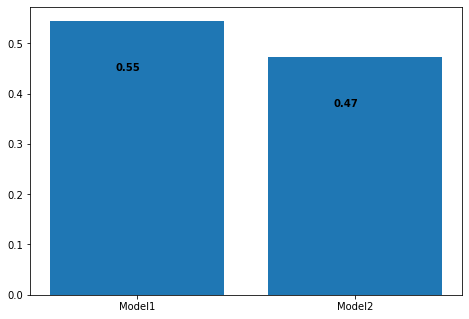

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(["Model1", "Model2"], Accuracy)
for i, v in enumerate([Accuracy1, Accuracy2]):
    ax.text(i - 0.1, v - 0.1, str(round(v, 2)), fontweight="bold")

As expected, the classification model (`Model1`) performs way better than the regression model (`Model2`) on our data. What would happen if we ensemble these 2 models together? Will the emsemble be able to learn from our Classifier and Regressor and perform better overall? Let's find out!

### 2. First-Level Base Model predictions on Validation data and Test data.

Here, we will be using our models to predict on both the validation data and the test data, and save these predictions in lists.
We will simply use the high-level `predict()` function to get the predictions and store these predictions in a list.

**Model1 Predictions**

In [12]:
validation_prediction_1 = []
async for i, features, prediction in predict(model1, *validation_data):
    validation_prediction_1.append(prediction["quality"]["value"])
print("First 5 Validation Predictions: ", validation_prediction_1[:5])

test_prediction_1 = []
async for i, features, prediction in predict(model1, *test_data):
    test_prediction_1.append(prediction["quality"]["value"])
print("First 5 Test Predictions: ", test_prediction_1[:5])

First 5 Validation Predictions:  [5, 6, 5, 5, 7]
First 5 Test Predictions:  [5, 7, 5, 5, 6]


**Model2 Predictions**

In [13]:
validation_prediction_2 = []
async for i, features, prediction in predict(model2, *validation_data):
    validation_prediction_2.append(prediction["quality"]["value"])
print("First 5 Validation Predictions: ", validation_prediction_2[:5])

test_prediction_2 = []
async for i, features, prediction in predict(model2, *test_data):
    test_prediction_2.append(prediction["quality"]["value"])
print("First 5 Test Predictions: ", test_prediction_2[:5])

First 5 Validation Predictions:  [5, 6, 5, 5, 6]
First 5 Test Predictions:  [4, 6, 5, 5, 5]


### 3. Stack Predictions. 

Now, we will stack all the validation predictions together into a list of dictionaries, and test predictions into another list of dictionaries. After this, we will have 2 lists consisting of stacked validation predictions and stacked test predictions.

In [14]:
validation_data[0].features()

{'fixed acidity': 8,
 'volatile acidity': 0.59,
 'citric acid': 0.05,
 'residual sugar': 2,
 'chlorides': 0.089,
 'free sulfur dioxide': 12,
 'total sulfur dioxide': 32,
 'density': 0.99735,
 'pH': 3.36,
 'sulphates': 0.61,
 'alcohol': 10,
 'quality': 5}

We can use the ground truth values saved in our records as the feature `"quality"`, to stack with the predictions as our `'y'` variable.

**Stacked Validation Predictions**

In [15]:
stacked_validation_predictions = []
for n_record in range(len(validation_data)):
    stacked_validation_predictions.append(
        {
            "x1": validation_prediction_1[n_record],
            "x2": validation_prediction_2[n_record],
            "y": validation_data[n_record].feature("quality"),
        }
    )
stacked_validation_predictions[0:5]

[{'x1': 5, 'x2': 5, 'y': 5},
 {'x1': 6, 'x2': 6, 'y': 6},
 {'x1': 5, 'x2': 5, 'y': 5},
 {'x1': 5, 'x2': 5, 'y': 5},
 {'x1': 7, 'x2': 6, 'y': 6}]

**Stacked Test Predictions**

In [16]:
stacked_test_predictions = []
for n_record in range(len(test_data)):
    stacked_test_predictions.append(
        {
            "x1": test_prediction_1[n_record],
            "x2": test_prediction_2[n_record],
            "y": test_data[n_record].feature("quality"),
        }
    )
stacked_test_predictions[0:5]

[{'x1': 5, 'x2': 4, 'y': 6},
 {'x1': 7, 'x2': 6, 'y': 7},
 {'x1': 5, 'x2': 5, 'y': 6},
 {'x1': 5, 'x2': 5, 'y': 6},
 {'x1': 6, 'x2': 5, 'y': 6}]

### 4. Build and Train Level-2 Meta-Model. 

The stacked validation predictions will serve as features to our level-2 meta-model. Classifiers clearly outperform regressors on the data we are using, so let's also use a classifier for our meta model. For this demo, we will use the Scikit SVC model available in DFFML by the entrypoint `"scikitsvc"`. 

**Build and train the meta-model**

In [17]:
metaModel = Model.load("scikitsvc")

features = Features(Feature("x1", int, 1), Feature("x2", int, 1),)

metaModel = metaModel(
    features=features, predict=Feature("y", int, 1), location="metaModel",
)
await train(metaModel, *stacked_validation_predictions)

In [18]:
EnsembleAcc = await accuracy(metaModel, scorer, *stacked_test_predictions)
Accuracy = [Accuracy1, Accuracy2, EnsembleAcc]
print("Accuracy of Ensemble Model:", EnsembleAcc)

Accuracy of Ensemble Model: 0.5763239875389408


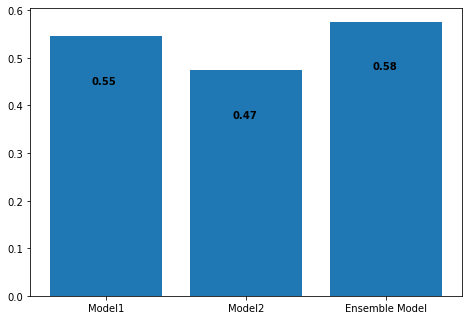

In [19]:
Accuracy = [Accuracy1, Accuracy2, EnsembleAcc]
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(["Model1", "Model2", "Ensemble Model"], Accuracy)
for i, v in enumerate(Accuracy):
    ax.text(i - 0.1, v - 0.1, str(round(v, 2)), fontweight="bold")

Our experiment was a success! It turns out the Ensemble model was after all able to learn somthing from not only the classifier but the regressor as well, and performed better than both.
Feel free to download the notebook and tune the models to get even better accuracies.

### 5. Final Prediction

Now our ensembled model is ready to perform the final predictions. We can simply go ahead and predict on stacked test predictions to get the final predcitions.

In [20]:
final_predictions = []
async for i, features, prediction in predict(metaModel, *stacked_test_predictions):
    final_predictions.append(prediction["y"]["value"])
print("First 5 Final Predictions: ", test_prediction_2[:5])

First 5 Final Predictions:  [4, 6, 5, 5, 5]
